# Twitter Texts Gender Prediction

Environment: Python 3.7 and Jupyter notebook

Libraries used:

* os (for os operation, included in Python 3.7)
* re (for extracting string, included in Python 3.7)
* nltk (for English processing)
* bs4 (beautifulSoup or pulling data out of XML files.)
* pyfunctools (seq - for convenient functional programming)
* sklearn (use for TF-IDF and other machine learning algorithms)
* functools (for partial function)
* collections (Counter, for counting the frequency of a list.)
* pandas (read and export file, included in Anaconda 3)
* operator
* numpy
* matplotlib (visualizations)
* string
* pywsd.utils (Lemmatization)
* scipy (`mode` function)
* tensorflow 2.0 (Deep Learning framework)

In [1]:
from bs4 import BeautifulSoup
from functional import seq  # install from `pip install pyfunctional`
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import os
from operator import itemgetter 
import numpy as np
from functools import partial
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode
import matplotlib.pyplot as plt
from string import digits
from pywsd.utils import lemmatize_sentence
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, BatchNormalization, Dropout, SimpleRNN, Flatten, Reshape, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import LeakyReLU, GlobalMaxPool1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, AveragePooling1D, Input, RNN, GRU, ReLU
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

Warming up PyWSD (takes ~10 secs)... took 3.0197980403900146 secs.
D:\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# 1.0 Introduction

This project is aim to:

Develop a classifier and this classifier is able to predict a label (male/ female) for each twitter author.

<b>The following are mainly part of this project:</b>

* Data Preparation & Feature Extraction
* Modelling (Neural networks, svc, knn, random forest, logistic regression will be used)
* Evaluation

# 2. Data Preparation & Feature Extraction

The dataset of this project is plenty of text files, the natural language cannot be input into any classification models. So, the data processing is an important preparation task of this project. For a better prediction and classification algorithm, we do some feature extraction by some particular technologies after data preparation. Then, select important features and consider them into models. 

<br/>

## 2.1 Data Preparation 

In this part, doing some data processing to make dataset and corpus more suitable for the further works. 

The tasks of this parts are:

- **Case normalization**: In this case, the contents of datasets are different tweets from 3600 people. The format of these tweets are quite different. So, make all letters as lower.


- **Remove Stopwords**: One of the major forms of pre-processing is to filter out useless data. In natural language processing, useless words (data), are referred to as stop words (GeeksforGeeks, 2017). Remove these stopwords, because they cannot represent any author's typing or speaking features.


- **Tokenization**: This is an important step for data processing by splitting each sentence into different single words. This make further works easier and better.



- **Remove useless characters**: After tokenization, there are many numbers and special characters. In this step, remove all special characters and numbers (includes emoji).




- **Lemmatization**: In this step, consider about the morphological analysis of the words, make all words into original form to decrease the size of dataset and corpus. Lemmatization is similar to stemming but it brings context to the words. So, it links words with similar meaning to one word. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words (GeeksforGeeks, 2019).


In [2]:
stopwords_list = stopwords.words('english') # import stop words

In [3]:
def get_text(tag):
    return tag.text

def remove_at_word(text: str) -> str:
    return re.sub(r"@.+?(?<= )", "", text)

# using 're' to remove all @ contents
def remove_url(text: str) -> str:
    return re.sub(r"https?:\/\/.+$", "", text)

# remove url address in each content of tweet by 'http'
def to_lowercase(text: str) -> str:
    return text.lower()

# transform all letters into lower
def remove_special(text: str) -> str:
    return re.sub(r'[^\w\s]', ' ', text)

# remove numbers, special characters and emoji
def remove_number(text: str) -> str:
    return text.translate({ord(x): None for x in digits})

# remove all digit numbers
def lemma(text: str) -> str:
    s = lemmatize_sentence(text)
    new_string = " ".join(s)
    return new_string

# doing lemmatization and then merge all words into a sentence
class Twitter:
    def __init__(self, text, gender):
        self.text = text
        self.tokens = seq(word_tokenize(self.text)) \
            .filter(lambda x: x not in stopwords_list)  # remove stopwords and doing tokenize
        self.gender = gender  # add gender parameter

    def __repr__(self):
        return self.text

    @staticmethod
    def merge(twitters):
        text = seq(twitters).map(lambda x: x.text).reduce(lambda x, y: x + y)
        gender = twitters[0].gender
        return Twitter(text, gender)
    # merge all tweets of one author

class Person:
    def __init__(self, xml_id, gender):
        # male 1, female 0
        self.gender = 1 if gender == "male" else 0
        # read xml file
        xml_path = os.path.join("data", xml_id + ".xml")
        # parse xml file as Twitter object
        soup = BeautifulSoup(open(xml_path, "r", encoding="UTF-8").read(), "xml")
        # 100 twitters
        self.twitters = seq(soup.find_all("document")) \
            .map(get_text).map(remove_at_word).map(remove_url) \
            .map(remove_special).map(to_lowercase).map(remove_number).map(lemma) \
            .map(lambda x: Twitter(x, self.gender))

    # merge all people's tweets together
    @staticmethod
    def build_from_csv_row(row):
        return Person(row[0], row[1])

    # merge all people's twitters together to extract concated tokens
    def merge_twitters(self):
        self.concated_tokens = self.twitters.map(lambda x: x.tokens).reduce(lambda x, y: x + y)
        return self

**Split the dataset:**

Using 0.1 ratio as the test size and random state 5149 to read our train data.

In [4]:
train, dev = train_test_split(pd.read_csv("train_labels.csv"), test_size=0.1, random_state=5149)
#split train label csv by 0.1 test ratio
train

,id,gender
2552,d7a113c4fe289a2d78477155725c3f9d,female
2726,8266d3bd79a0560b878394651e0cd5cf,female
1586,d1d4dddcf7a465ac87a2d97116ceb091,male
876,6c92bebe2dabbdeccbc7bdaa4bf9292f,male
138,f52f7db6aef63033c02869a3ecf53abc,female
...,...,...
1853,e1ec6ac163cc6e46c593d672498bbc81,female
554,f6c0270a2b0ac5c3cca89e0fd41707e7,male
2778,aea34189d5f10ddd240d13763c2ece6e,female
2438,dfbad9e82cd2cd86c6f9067bc8cd4afa,male


Read test csv file to input test data, just extract the id number and corresponding gender from this file.

In [5]:
test = pd.read_csv("test.csv").loc[:,["id", "gender"]] 
# read test file, select id and gender
test

,id,gender
0,d6b08022cdf758ead05e1c266649c393,NaN
1,9a989cb04766d5a89a65e8912d448328,NaN
2,2a1053a059d58fbafd3e782a8f7972c0,NaN
3,6032537900368aca3d1546bd71ecabd1,NaN
4,d191280655be8108ec9928398ff5b563,NaN
...,...,...
495,22ccbc021f5647fb937a244f2b20c481,NaN
496,cefc8ef7699a7cdea083fb104c46b4f4,NaN
497,356da3bba0e1527fb5781865c45ad272,NaN
498,6e12611644ba86570349192a2e960e3,NaN


**The result of data processing**:

After input and read our dataset files, using 'Person' class to explore the results of data processing. 

By compare with original data and processed data, we can find:

- Each sentence has been split into single words 

- All words into original form, the size of datasets has been decreased.

- All stop words and special characters have been removed (includes emoji)

The result of data processing is good enough for the further works.


In [6]:
Person("2179e5386cc781214f6a568e1447a896", "female").twitters[42]
#display one person's tweets after data processing

good luck helen for your future endeavour and thank you for be someone to look up to

In [7]:
Person("2179e5386cc781214f6a568e1447a896", "female").gender

0

## 2.2 Feature Extraction

After finishing data preprocessing, start to find the features of each author's tweets. The method has been chosen in this part is: **TF-IDF**. 

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents (Stecanella,2019).

The equation of TF-IDF: 

$$W_x,_y=tf_x,_y  \times  log(\frac{N}{df_x}) $$    

 $tf_x,_y $ is the frequency of x in y
 
 $df_x$ is the number of documents containing x.
 
 $N$ is the total number of documents
 
 
Creating a class 'Data' to contain the function of extract each tweeter's gender, id and corpus.

In [8]:
class Data:
    def __init__(self, train_xmls):
        # all persons
        self.persons = seq(train_xmls.apply(Person.build_from_csv_row, axis=1))
        # all flattened twitters
        self.twitters = self.persons.map(lambda x: x.twitters).flatten()
    
    def get_y(self):
        # get labels
        return np.array(self.persons.map(lambda x: x.gender).to_list())
    
    def get_corpus(self):
        return self.persons.map(lambda person: person.merge_twitters().concated_tokens.to_list()).to_list()

In [16]:
%%time
# Using class 'Data' to transform each data file.
train_data = Data(train) 
dev_data = Data(dev)
test_data = Data(test)

Wall time: 13.5 s


**Corpus:**

The corpus is important for TF-IDF, the best size of corpus cannot be too large or small. 
First step is using `get_corpus` method of `Data` class to extract the corpus for each data (train, dev and test). 

As the size of each dataset is very large, it costs about 25 minutes for running these codes. So, the `json` library is used to write all data into corresponding json files for easier experiments.

The json files are provided already in Google Drive. So please feel free to skip the corpus extraction process.

https://drive.google.com/drive/folders/1gDoW8TeEpxRuQnq71bFtdIUlZzQCYWFG?usp=sharing

<b>Hint: Time consuming. They need about 25 minutes to run.</b>

In [16]:
%%time
corpus_train = train_data.get_corpus()

Wall time: 18min 51s


In [17]:
%%time
corpus_dev = dev_data.get_corpus()

Wall time: 2min 4s


In [18]:
%%time
corpus_test = test_data.get_corpus()

Wall time: 3min 25s


In [22]:
corpus = corpus_train + corpus_dev + corpus_test

In [23]:
with open("corpus.json", "w", encoding="UTF-8") as file:
     file.write(json.dumps(corpus))
    
with open("corpus_train.json", "w", encoding="UTF-8") as file:
     file.write(json.dumps(corpus_train))
    
with open("corpus_dev.json", "w", encoding="UTF-8") as file:
     file.write(json.dumps(corpus_dev))

with open("corpus_test.json", "w", encoding="UTF-8") as file:
     file.write(json.dumps(corpus_test))

In [9]:
# load these json files so the tfidf process can be skipped
with open("corpus.json", "r", encoding="UTF-8") as file:  
    corpus = json.loads(file.read())

with open("corpus_train.json", "r", encoding="UTF-8") as file:
    corpus_train = json.loads(file.read())
    
with open("corpus_dev.json", "r", encoding="UTF-8") as file:
    corpus_dev = json.loads(file.read())
    
with open("corpus_test.json", "r", encoding="UTF-8") as file:
    corpus_test = json.loads(file.read())

In [10]:
len(corpus)

3600

Visualize the frequency distribution of words in corpus.

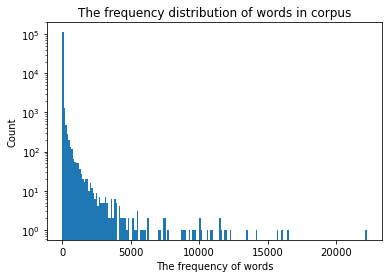

In [11]:
token_freqs = Counter([token for twitter in corpus for token in twitter]).values()

plt.hist(token_freqs, 200)
plt.yscale("log")
plt.xlabel('The frequency of words')
plt.ylabel('Count')
plt.title('The frequency distribution of words in corpus')
plt.show()

From the visualization, almost words do not have a high frequency. This is a key point for our doing TF-IDF in next steps.

For the TF-IDF settings, set the max frequency of the words in corpus less than 95%, because we can see not many words have more 95% frequency in the plot. 

For the minimum frequency of the words in corpus, we try to use different number of it by 8, 100 or 5%. 
The result of 8 is the most suitable one and can make sense, with 15381 words.

In [12]:
# set the min number and max frequence of words in corpus
tfidf_vec = TfidfVectorizer(preprocessor=' '.join,sublinear_tf=True, max_df=0.95, min_df=8)
tfidf_vec.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=8, ngram_range=(1, 1), norm='l2',
                preprocessor=<built-in method join of str object at 0x000001E6404493B0>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [13]:
tfidf_vec.transform(corpus_dev).shape # check the shape of corpus's files and words after tf-idf

(310, 15381)

In [14]:
# transform all tf-idf results into corrsponding array
x_train_tfidf = tfidf_vec.transform(corpus_train).toarray()
x_dev_tfidf = tfidf_vec.transform(corpus_dev).toarray()
x_test_tfidf = tfidf_vec.transform(corpus_test).toarray() 

In [17]:
y_train = train_data.get_y()
y_dev = dev_data.get_y()

Save the results of TF-IDF to `npy` files for easier and faster experiments.

In [33]:
# save each array as npy files for further works
np.save("x_train_tfidf.npy", x_train_tfidf) 
np.save("x_dev_tfidf.npy", x_dev_tfidf)
np.save("x_test_tfidf.npy", x_test_tfidf)

np.save("y_train_tfidf.npy", y_train)
np.save("y_dev_tfidf.npy", y_dev)

# 3. Modelling

Load the data from `npy` file. If only doing the experiments, the Section 2.2 can be skipped to save time.

In [9]:
# read these npy files 
x_train_tfidf = np.load("x_train_tfidf.npy") 
x_dev_tfidf = np.load("x_dev_tfidf.npy")
x_test_tfidf = np.load("x_test_tfidf.npy")

y_train = np.load("y_train_tfidf.npy")
y_dev = np.load("y_dev_tfidf.npy")

In [10]:
x_train_tfidf.shape # the final shpae of tf-idf results of train dataset in total corpus

(2790, 15381)

In [12]:
# set GPU memeory growth for tensorflow
# if no GPU, skip this

# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Define a function for easier evaluate accuracy for predicted values

In [13]:
def evaluate_accuracy(data):
    def evaluate(y_pred):
        return sum(y_pred == (data.gender == "male").astype(int).to_numpy()) / len(data)
    return evaluate

evaluate_dev_accuracy = evaluate_accuracy(dev)

## 3.1 Modelling with TF-IDF
### 3.1.1 Support Vector Machine Classifier

Support Vector Machine Classifier (SVC) prefer doing a better works on classifying the most of observation by misclassifying a few training observation. Some observation is allowed on the incorrect side of margin or hyperplane.
\begin{align}\overset{\large maximize {\LARGE M}}{\beta_0,\beta_1,...,\beta_p,\epsilon_1, ...,\epsilon_n,M}\end{align}
\begin{align}\text {subject to} {\sum_{j=1}^p\beta_j^2 = 1,}\end{align}
\begin{align}y_i (\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + ... + \beta_px_{ip} \ge  M (1 - \epsilon_i),\end{align}
\begin{align}\epsilon_i \ge 0, \sum_{i=1}^n \epsilon_i \le C\end{align}

* $\Large c$ is a nonnegative tuning parameter and this is like a budget for violation of margin and hyperplane . $\large M$ is the width of the margin.
* $\epsilon_1, ...,\epsilon_n$ are slack variables which permit some observation in wrong side of margin or the hyperplane. slack variable tells the location of $ith$ observation. When $\epsilon_i = 0$, the observation is in correct side. If $\epsilon_i > 0$，it is on the wrong side of margin. Meanwhile, if $\epsilon_i$ > 1 it is on the wrong side of hyperplane (James, et al., 2015).


<b>Advantage:</b>
* high performance on classifying classes with clear margin of separation.
* works affectively in high dimensional spaces.
* memory efficient

<b>Disadvantage:</b>
* not for large data sets
* low performance (target classes overlapping)
* have no probabilistic explanation


In [14]:
def build_svc(C, kernel, X, y):
    return SVC(C=C, kernel=kernel, max_iter=100, random_state=5149, tol=0.05).fit(X=X, y=y)

build_svc_tfidf = partial(build_svc, X=x_train_tfidf, y=y_train)

#### Hyperparameter Grid Search 

<b>Time consuming!</b>

In [24]:
# %%time
# # set hyperparameter search in log scale
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# svc_tfidf_hyperparameter = [(kernel, 10 ** c) for c in range(-3, 6) for kernel in kernels]
# svc_tfidf_models = []
# svc_tfidf_accuracy = []

# for kernel, c in svc_tfidf_hyperparameter:
#     svc_tfidf = build_svc_tfidf(c, kernel)
#     svc_tfidf_models.append(svc_tfidf)
#     svc_tfidf_pred = svc_tfidf.predict(x_dev_tfidf)
#     svc_tfidf_accuracy.append(evaluate_dev_accuracy(svc_tfidf_pred))

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warni

Wall time: 5min 23s


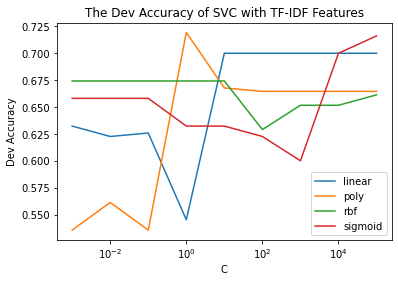

In [100]:
# def get_svc_accuracy_from_kernel(kernel, accuracy_list, hyperparameter_list):
#     return [accuracy_list[i] for i in range(len(accuracy_list)) if hyperparameter_list[i][0] == kernel]
    
# svc_tfidf_linear_accuracy = get_svc_accuracy_from_kernel("linear", svc_tfidf_accuracy, svc_tfidf_hyperparameter)
# svc_tfidf_poly_accuracy = get_svc_accuracy_from_kernel("poly", svc_tfidf_accuracy, svc_tfidf_hyperparameter)
# svc_tfidf_rbf_accuracy = get_svc_accuracy_from_kernel("rbf", svc_tfidf_accuracy, svc_tfidf_hyperparameter)
# svc_tfidf_sigmoid_accuracy = get_svc_accuracy_from_kernel("sigmoid", svc_tfidf_accuracy, svc_tfidf_hyperparameter)

# x = np.power(10., np.array(range(-3, 6)))

# plt.figure()
# plt.plot(x, svm_tfidf_linear_accuracy)
# plt.plot(x, svm_tfidf_poly_accuracy)
# plt.plot(x, svm_tfidf_rbf_accuracy)
# plt.plot(x, svm_tfidf_sigmoid_accuracy)
# plt.xscale("log")
# plt.legend(kernels)
# plt.ylabel("Dev Accuracy")
# plt.xlabel("C")
# plt.title("The Dev Accuracy of SVC with TF-IDF Features")
# plt.show()

#### Choose best hyperparameter

In [29]:
# svc_tfidf_hyperparameter[svc_tfidf_accuracy.index(max(svc_tfidf_accuracy))]

('poly', 1)

In [15]:
svc_tfidf = build_svc_tfidf(1, "poly")
svc_tfidf_pred = svc_tfidf.predict(x_dev_tfidf)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [16]:
evaluate_dev_accuracy(svc_tfidf_pred)

0.7193548387096774

### 3.1.2 KNN

The output of this algorithm depends on the class of the k nearest neighbourhoods.  Then the output is the label by the majority of labels which are owned by the nearest neighbourhoods.

The most common method to calculate the neighbour distance is Euclidean distance between the two in predictor space: 
\begin{align}D_{euc} = \sqrt{\sum_{i=1}^k (x_i-y_i)^2}\end{align}

$D_{euc}$ is the distance between x and y, $i$ is current feature and  n is the total number of feature (Ozcoban et al., 2018).

<b>Advantage:</b>
* nonparametric
* no cost on learning process
* suitable for multi-classes

<b>Disadvantage:</b>
* calculate nearest neighbour for large data sets need large amount of time
* sensitivity on noisy data
* performance is affected by the number of features


#### Hyperparameter Grid Search 

<b> Hint: Very time consuming </b>

In [12]:
# %%time

# knn_tfidf_hyperparameter = range(1, 120)
# knn_tfidf_models = []
# knn_tfidf_accuracy = []
# for k in range(1, 150):
#     knn_tfidf = KNeighborsClassifier(k).fit(X=x_train_tfidf, y=y_train)
#     knn_tfidf_models.append(knn_tfidf)
#     knn_tfidf_pred = knn_tfidf.predict(x_dev_tfidf)
#     knn_tfidf_accuracy.append(evaluate_dev_accuracy(knn_tfidf_pred))

CPU times: user 55min 17s, sys: 7.74 s, total: 55min 25s
Wall time: 55min 15s


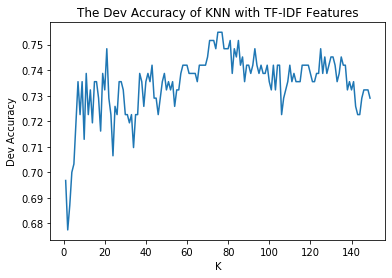

In [13]:
# x = range(1, 150)

# plt.figure()
# plt.plot(x, knn_tfidf_accuracy)
# plt.ylabel("Dev Accuracy")
# plt.xlabel("K")
# plt.title("The Dev Accuracy of KNN with TF-IDF Features")
# plt.show()

#### Choose best hyperparameter

In [28]:
# print("Best Hyperparameter:", x[knn_tfidf_accuracy.index(max(knn_tfidf_accuracy))])

75

In [17]:
knn_tfidf = KNeighborsClassifier(75).fit(X=x_train_tfidf, y=y_train)
knn_tfidf_pred = knn_tfidf.predict(x_dev_tfidf)
evaluate_dev_accuracy(knn_tfidf_pred)

0.7548387096774194

### 3.1.3 Random Forest

Random Forest classifier is based on an ensemble of decision trees, but it used random of subset of samples for growing a tree(i.e. every node splitter is determined randomly). This is helpful for improving the accuracy (Narayan & Bhalja, 2017).


<b>Advantage:</b>
- Random Forest is usually can handle outlier automatically
- Random Forest algorithm is very stable
- less impacted by noise.

<b>Disadvantage:</b>
- hard to interpret
- overfit for some datasets
- For data with different levels of categorical variables, the random forest tends to support data with higher levels of attributes. Thus, variable importance scores from random forests are unreliable for such data.


#### Hyperparameter Grid Search

In [32]:
# %%time

# criterions = ("gini", "entropy")
# rf_tfidf_hyperparameter = [(n, criterion) for n in list(range(50, 1001, 50)) for criterion in criterions]
# rf_tfidf_accuracy = []
# # set criterion
# for n, criterion in rf_tfidf_hyperparameter:
#     # build rf
#     rf_tfidf = RandomForestClassifier(n_estimators=n, criterion=criterion, random_state=5149).fit(X=x_train_tfidf, y=y_train)
#     # predict
#     rf_tfidf_pred = rf_tfidf.predict(x_dev_tfidf)
#     # calculate accuracy
#     rf_tfidf_accuracy.append(evaluate_dev_accuracy(rf_tfidf_pred))

Wall time: 20min 2s


In [33]:
# def get_rf_accuracy_from_criterion(criterion, accuracy_list, hyperparameter_list):
#     return [accuracy_list[i] for i in range(len(accuracy_list)) if hyperparameter_list[i][1] == criterion]
    
# rf_tfidf_gini_accuracy = get_rf_accuracy_from_criterion("gini", rf_tfidf_accuracy, rf_tfidf_hyperparameter)
# rf_tfidf_entropy_accuracy = get_rf_accuracy_from_criterion("entropy", rf_tfidf_accuracy, rf_tfidf_hyperparameter)

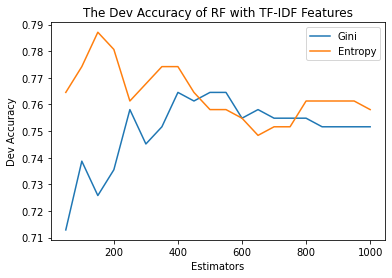

In [34]:
# x = list(range(50, 1001, 50))

# plt.figure()
# plt.plot(x, rf_tfidf_gini_accuracy)
# plt.plot(x, rf_tfidf_entropy_accuracy)
# plt.ylabel("Dev Accuracy")
# plt.xlabel("Estimators")
# plt.legend(["Gini", "Entropy"])
# plt.title("The Dev Accuracy of RF with TF-IDF Features")
# plt.show()

#### Choose best model

In [35]:
# rf_tfidf_hyperparameter[rf_tfidf_accuracy.index(max(rf_tfidf_accuracy))]

(150, 'entropy')

In [18]:
rf_tfidf = RandomForestClassifier(n_estimators=150, criterion="entropy", random_state=5149).fit(X=x_train_tfidf, y=y_train)
rf_tfidf_pred = rf_tfidf.predict(x_dev_tfidf)
evaluate_dev_accuracy(rf_tfidf_pred)

0.7870967741935484

### 3.1.4 Logistic Regression

Logistic Regression models the conditional probabilities and extend the linear regression model to binary data. Usually this used to calculate the probability of a class. If the Probability > 50%, the event is classified into this class. 

<b>Advantage</b>
- highly interpretable
- not need scaled input feature and tuning
- easy to regularize
- easy to implement and very efficient to train

<b>Disadvantage</b>
- cannot solve non-linear classification problems
- slower and bad performance with huge amount of data and many numbers of features.

In [19]:
lr_tfidf_hyperparameter = [(10 ** C, l1) for C in range(-3, 6) for l1 in np.linspace(0, 0.5, 11)]

def get_lr_accuracy(hyperparameter):
    C, l1 = hyperparameter
    lr_tfidf = LogisticRegression(C=C, l1_ratio=l1, penalty="elasticnet", solver="saga", max_iter=200).fit(X=x_train_tfidf, y=y_train)
    lr_tfidf_pred = lr_tfidf.predict(x_dev_tfidf)
    return evaluate_dev_accuracy(lr_tfidf_pred)

#### Hyperparameter Grid Search
The Pool is only available in MacOS. If the system is Windows, please use the code instead of `Pool`.

In [12]:
# %%time

# from multiprocessing import Pool

# # if MacOS
# # p = Pool()
# # lr_tfidf_accuracy = list(p.map(get_lr_accuracy, lr_tfidf_hyperparameter))

# # if Windows
# lr_tfidf_accuracy = list(map(get_lr_accuracy, lr_tfidf_hyperparameter))

/Users/yanglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yanglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yanglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yanglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yanglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: C

CPU times: user 786 ms, sys: 249 ms, total: 1.03 s
Wall time: 20min 50s


In [77]:
# # first hyperparameter (C Aka. L2)
# fs_list = [x[0] for x in lr_tfidf_hyperparameter]
# # second hyperparameter (L1)
# se_list = [round(x[1], 2) for x in lr_tfidf_hyperparameter]

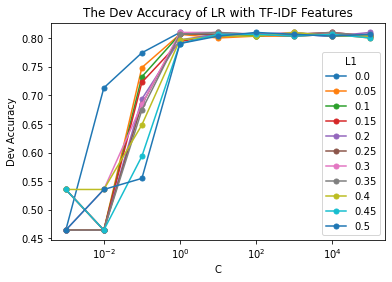

In [79]:
# lr_df = pd.DataFrame({'L2' : fs_list,'L1': se_list, 'Accuracy' : lr_tfidf_accuracy}, 
#                      columns=['L1','L2', 'Accuracy'])

# groups = lr_df.groupby('L1')
# fig, ax = plt.subplots()
# for name, group in groups:
#     ax.plot(group.L2, group.Accuracy, marker='o', linestyle='-', ms=5, label=name)
# ax.legend(title="L1", loc='lower right')
# ax.set_xlabel('C')
# ax.set_ylabel('Dev Accuracy')
# ax.set_title('The Dev Accuracy of LR with TF-IDF Features')
# plt.xscale('log')
# plt.show()

#### Choose best model

In [232]:
# print("Best hyperparameter:")
# for i in range(len(lr_tfidf_accuracy)):
#     if lr_tfidf_accuracy[i] == max(lr_tfidf_accuracy):
#         print(lr_tfidf_hyperparameter[i])

Best hyperparameter:
(1, 0.0)
(1, 0.30000000000000004)
(10, 0.1)
(10, 0.30000000000000004)
(10, 0.35000000000000003)
(100, 0.5)
(1000, 0.1)
(1000, 0.30000000000000004)
(1000, 0.4)
(10000, 0.15000000000000002)
(10000, 0.35000000000000003)
(100000, 0.2)


According to the documentation of sklearn, when C is large, the constrain of model is less, which means overfitting. 

Therefore, to choose a less complex model, the first one with lowest C value is chosen.

In [20]:
lr_tfidf = LogisticRegression(C=1, l1_ratio=0, penalty="elasticnet", solver="saga", max_iter=200).fit(X=x_train_tfidf, y=y_train)
lr_tfidf_pred = lr_tfidf.predict(x_dev_tfidf)
evaluate_dev_accuracy(lr_tfidf_pred)

0.8096774193548387

## 3.2 Modelling with NN Hidden Features

### 3.2.1 Neural Networks

The Neural Networks (NN) in this project is not only the classifier, but also the feature extractor. For more details of the strcuture and the explanation of models, please refer to the report pdf.

The first step is to build the Neural Network by library `Tensorflow.keras`

#### Neural Network Structures

In [21]:
def build_nn():
    # input layer
    x_in = Input(15381)
    x = Dropout(0.75)(x_in)
    
    # first hidden layer
    x = Dense(1024, kernel_regularizer=l1_l2(l1 = 0.0005, l2 = 0.001))(x)
    x = LeakyReLU(0.2)(x)
    feature = BatchNormalization()(x)
    x = Dropout(0.75)(x)
    
    # second hidden layer
    x = Dense(128, kernel_regularizer=l1_l2(l1 = 0, l2 = 0.001))(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # output layer
    x = Dense(1, kernel_regularizer=l1_l2(l1 = 0, l2 = 0.001), activation="sigmoid")(x)
    return Model(x_in, x), Model(x_in, feature)

nn, feature_extractor = build_nn()

In [22]:
nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15381)]           0         
_________________________________________________________________
dropout (Dropout)            (None, 15381)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              15751168  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0     

In [23]:
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15381)]           0         
_________________________________________________________________
dropout (Dropout)            (None, 15381)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              15751168  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
Total params: 15,755,264
Trainable params: 15,753,216
Non-trainable params: 2,048
_________________________________________________________________


#### Neural Network Training

From the `summary` method of the model, the structure of the NN classifier and feature extractor is displayed above.

The next step is to compare the training process of NN, which includes:
* Model compile: Setting the optimizer `Adam`, loss `binary_crossentropy` and metrics `accuracy`.
* Set learning rate reduction: When the training loss do not decrease, set the learning rate as 50% of previous learning rate. 
* Define a `evaluate` funtion: The function is defined for evaluate the NN with `dev` data.
* Set a `history` variable: The variable is for logging the history for visualization 
* Define a Callback function: The function is for logging the history and detect early stop

In [24]:
nn.compile(Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# set a training callback for learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000000001)

# the function to evaluate accuracy of neural networks with dev data
def evaluate(model):
    return sum((model.predict(x_dev_tfidf) > 0.5).reshape(-1) == (dev.gender == "male").astype(int).to_numpy()) / len(dev)
        
# set history variable
history = {"loss":[], "accuracy":[], "val_accuracy":[], "val_loss":[]}
# define a callback function to used in each epoch
def check_val_loss(batch, logs):
    # log the history
    for each in history.keys():
        history[each].append(logs[each])
    # set early stop when the accuracy of dev data is larger than 84%.
    if logs["val_accuracy"] > 0.83:
        print("Val_loss = ", logs["val_loss"])
        print("Val_accuracy = ", logs["val_accuracy"])
        raise KeyboardInterrupt

epoch_print_callback = LambdaCallback(on_epoch_end=check_val_loss)

Train the NN by using GPU. If no GPU available, it will be extremely time comsuming. 

The training of NN in `Tensorflow.keras` is not easy to be reproductive by simply setting seed. Therefore, the training process is different and unstable in each time. Sometimes, the final result of accuracy in dev data can be 83.5%, but sometimes it is only 80%. So, it needs some luck.

Sometimes, the early stop callback function can catch the chance when the accuracy is larger than 83%, but it will not happen in each time.

In [25]:
nn.fit(x_train_tfidf, y_train, epochs=150, batch_size=64, 
       callbacks=[learning_rate_reduction, epoch_print_callback], 
       validation_data=[x_dev_tfidf, y_dev], verbose=2)

Train on 2790 samples, validate on 310 samples
Epoch 1/150
2790/2790 - 2s - loss: 25.0207 - accuracy: 0.6183 - val_loss: 11.2979 - val_accuracy: 0.7452
Epoch 2/150
2790/2790 - 1s - loss: 8.8272 - accuracy: 0.7237 - val_loss: 7.5592 - val_accuracy: 0.7806
Epoch 3/150
2790/2790 - 1s - loss: 6.8321 - accuracy: 0.7290 - val_loss: 6.4891 - val_accuracy: 0.7742
Epoch 4/150
2790/2790 - 1s - loss: 6.1081 - accuracy: 0.7348 - val_loss: 6.0969 - val_accuracy: 0.7742
Epoch 5/150
2790/2790 - 1s - loss: 5.5975 - accuracy: 0.7358 - val_loss: 5.3950 - val_accuracy: 0.7806
Epoch 6/150
2790/2790 - 1s - loss: 5.1088 - accuracy: 0.7398 - val_loss: 5.1601 - val_accuracy: 0.7355
Epoch 7/150
2790/2790 - 1s - loss: 4.8984 - accuracy: 0.7505 - val_loss: 4.9912 - val_accuracy: 0.7516
Epoch 8/150
2790/2790 - 1s - loss: 4.6996 - accuracy: 0.7484 - val_loss: 4.7750 - val_accuracy: 0.7323
Epoch 9/150
2790/2790 - 1s - loss: 4.5589 - accuracy: 0.7509 - val_loss: 4.6515 - val_accuracy: 0.7613
Epoch 10/150
2790/2790 -

Evaluate the model to see the accuracy of the dev data.

In [26]:
evaluate(nn)

0.8064516129032258

In [25]:
nn = load_model("model_tfidf_submit.h5")

feature_extractor = Sequential()
for layer in nn.layers[:-6]:
    feature_extractor.add(layer)

Evaluate the best model made to see the acccuracy of dev data.

In [26]:
evaluate(nn)

0.8129032258064516

Apply the NN feature extractor to 

In [27]:
x_train_feature = feature_extractor.predict(x_train_tfidf)
x_dev_feature = feature_extractor.predict(x_dev_tfidf)
x_test_feature = feature_extractor.predict(x_test_tfidf)

Apply the PCA to visualize the results of distribution of original TF-IDF features and NN hidden features.

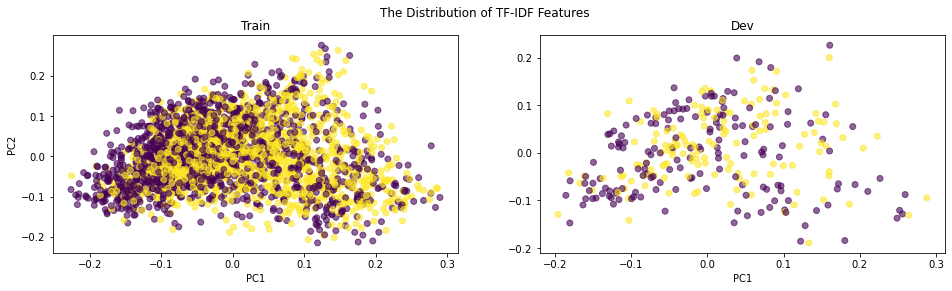

In [28]:
pca = PCA(2)

x_train_pca = pca.fit_transform(x_train_tfidf)
x_dev_pca = pca.transform(x_dev_tfidf)
x_train_pca.shape

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.scatter(x=x_train_pca[:,0], y=x_train_pca[:,1], c=y_train, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Train")
plt.subplot(1, 2, 2)
plt.scatter(x=x_dev_pca[:,0], y=x_dev_pca[:,1], c=y_dev, alpha=0.6)
plt.xlabel("PC1")
plt.title("Dev")
plt.suptitle("The Distribution of TF-IDF Features")
plt.show()

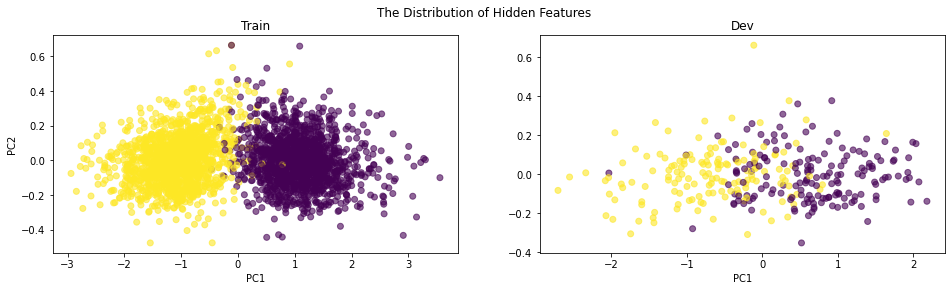

In [29]:
pca = PCA(2)

x_train_pca = pca.fit_transform(x_train_feature)
x_dev_pca = pca.transform(x_dev_feature)
x_train_pca.shape

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.scatter(x=x_train_pca[:,0], y=x_train_pca[:,1], c=y_train, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Train")
plt.subplot(1, 2, 2)
plt.scatter(x=x_dev_pca[:,0], y=x_dev_pca[:,1], c=y_dev, alpha=0.6)
plt.xlabel("PC1")
plt.title("Dev")
plt.suptitle("The Distribution of Hidden Features")
plt.show()

From the output, the hidden features extracted by NN is more separable than TF-IDF features. Therefore, the machine learning classifiers might perform better in the NN hidden features.

The visualization below is about the training process in training.

Text(0.5, 1.0, 'Loss in NN Training')

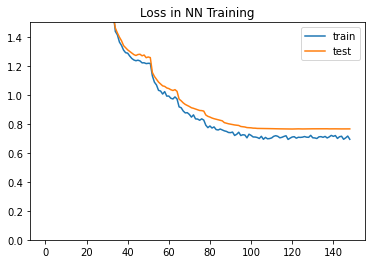

In [66]:
n = len(history["loss"])-1

plt.figure()
plt.plot(range(n), history["loss"][:n])
plt.plot(range(n), history["val_loss"][:n])
plt.ylim(0, 1.5)
plt.legend(["train", "test"])
plt.title("Loss in NN Training")

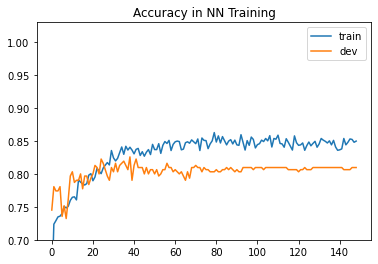

In [67]:
plt.figure()
plt.plot(range(n), history["accuracy"][:n])
plt.plot(range(n), history["val_accuracy"][:n])
plt.ylim(0.7, 1.03)
plt.title("Accuracy in NN Training")
plt.legend(["train", "dev"])

From the outputs, the overfitting problem exists, but acceptable.

Next step is building machine learning classifiers with the NN hidden features.

### 3.2.2 Support Vector Machine Classifier

In [30]:
build_svc_hidden = partial(build_svc, X=x_train_feature, y=y_train)

#### Hyperparameter Grid Search

In [108]:
# %%time
# # set hyperparameter search in log scale
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# svc_hidden_hyperparameter = [(kernel, 10 ** c) for c in range(-3, 10) for kernel in kernels]
# svc_hidden_models = []
# svc_hidden_accuracy = []

# for kernel, c in svc_hidden_hyperparameter:
#     svc_hidden = build_svc_hidden(c, kernel)
#     svc_hidden_models.append(svc_hidden)
#     svc_hidden_pred = svc_hidden.predict(x_dev_feature)
#     svc_hidden_accuracy.append(evaluate_dev_accuracy(svc_hidden_pred))

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warni

Wall time: 23.9 s


D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


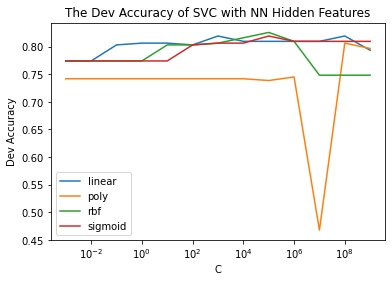

In [117]:
# svc_hidden_linear_accuracy = get_svc_accuracy_from_kernel("linear", svc_hidden_accuracy, svc_hidden_hyperparameter)
# svc_hidden_poly_accuracy = get_svc_accuracy_from_kernel("poly", svc_hidden_accuracy, svc_hidden_hyperparameter)
# svc_hidden_rbf_accuracy = get_svc_accuracy_from_kernel("rbf", svc_hidden_accuracy, svc_hidden_hyperparameter)
# svc_hidden_sigmoid_accuracy = get_svc_accuracy_from_kernel("sigmoid", svc_hidden_accuracy, svc_hidden_hyperparameter)

# x = np.power(10., np.array(range(-3, 10)))

# plt.figure()
# plt.plot(x, svc_hidden_linear_accuracy)
# plt.plot(x, svc_hidden_poly_accuracy)
# plt.plot(x, svc_hidden_rbf_accuracy)
# plt.plot(x, svc_hidden_sigmoid_accuracy)
# plt.xscale("log")
# plt.legend(kernels)
# plt.ylabel("Dev Accuracy")
# plt.xlabel("C")
# plt.title("The Dev Accuracy of SVC with NN Hidden Features")
# plt.show()

#### Choose best model

In [118]:
# svc_hidden_hyperparameter[svc_hidden_accuracy.index(max(svc_hidden_accuracy))]

('rbf', 100000)

In [31]:
svc_hidden = SVC(C=100000, kernel="rbf", random_state=5149).fit(X=x_train_feature, y=y_train)
svc_hidden_pred = svc_hidden.predict(x_dev_feature)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [32]:
evaluate_dev_accuracy(svc_hidden_pred)

0.8129032258064516

### 3.2.3 KNN

#### Hyperparameter Grid Search

In [160]:
# %%time

# knn_hidden_hyperparameter = range(1, 120)
# knn_hidden_models = []
# knn_hidden_accuracy = []
# knn_hidden_accuracy_test = []
# for k in range(1, 150):
#     knn_hidden = KNeighborsClassifier(k).fit(X=x_train_feature, y=y_train)
#     knn_hidden_models.append(knn_hidden)
#     knn_hidden_pred = knn_hidden.predict(x_dev_feature)
#     knn_hidden_accuracy.append(evaluate_dev_accuracy(knn_hidden_pred))

Wall time: 2min 36s


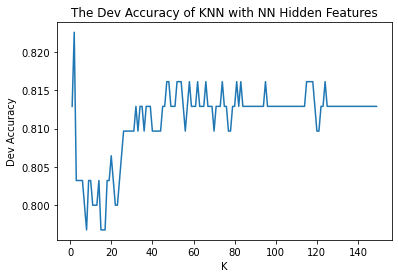

In [161]:
# x = range(1, 150)

# plt.figure()
# plt.plot(x, knn_hidden_accuracy)
# plt.ylabel("Dev Accuracy")
# plt.xlabel("K")
# plt.title("The Dev Accuracy of KNN with NN Hidden Features")
# plt.show()

#### Choose best model

In [168]:
# print("Best hyperparameter:", x[knn_hidden_accuracy.index(max(knn_hidden_accuracy))])

Best hyperparameter: 2


In [33]:
knn_hidden = KNeighborsClassifier(2).fit(X=x_train_feature, y=y_train)
knn_hidden_pred = knn_hidden.predict(x_dev_feature)

evaluate_dev_accuracy(knn_hidden_pred)

0.8225806451612904

### 3.2.4 Random Forest

#### Hyperparameter Grid Search

In [172]:
# %%time

# criterions = ("gini", "entropy")
# rf_hidden_hyperparameter = [(n, criterion) for n in list(range(50, 1001, 50)) for criterion in criterions]
# rf_hidden_accuracy = []
# # set criterion
# for n, criterion in rf_hidden_hyperparameter:
#     # build rf
#     rf_hidden = RandomForestClassifier(n_estimators=n, criterion=criterion, random_state=5149).fit(X=x_train_feature, y=y_train)
#     # predict
#     rf_hidden_pred = rf_hidden.predict(x_dev_feature)
#     # calculate accuracy
#     rf_hidden_accuracy.append(evaluate_dev_accuracy(rf_hidden_pred))

Wall time: 3min 33s


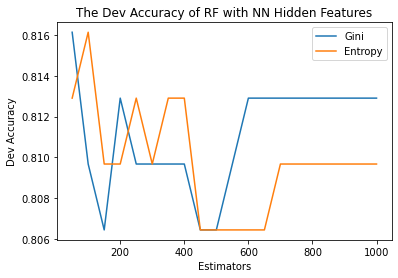

In [174]:
# rf_hidden_gini_accuracy = get_rf_accuracy_from_criterion("gini", rf_hidden_accuracy, rf_hidden_hyperparameter)
# rf_hidden_entropy_accuracy = get_rf_accuracy_from_criterion("entropy", rf_hidden_accuracy, rf_hidden_hyperparameter)

# x = list(range(50, 1001, 50))

# plt.figure()
# plt.plot(x, rf_hidden_gini_accuracy)
# plt.plot(x, rf_hidden_entropy_accuracy)
# plt.ylabel("Dev Accuracy")
# plt.xlabel("Estimators")
# plt.legend(["Gini", "Entropy"])
# plt.title("The Dev Accuracy of RF with NN Hidden Features")
# plt.show()

#### Choose best model

In [190]:
# print("Best hyperparameter:")
# for i in range(len(rf_hidden_accuracy)):
#     if rf_hidden_accuracy[i] == max(rf_hidden_accuracy):
#         print(rf_hidden_hyperparameter[i])

Best hyperparameter:
(50, 'gini')
(100, 'entropy')


There are 2 maximum value. The first one (50, gini) with less number of estimators are chosen for less comlexity of model.

In [34]:
rf_hidden = RandomForestClassifier(n_estimators=50, criterion="gini", random_state=5149).fit(X=x_train_feature, y=y_train)
rf_hidden_pred = rf_hidden.predict(x_dev_feature)

In [35]:
evaluate_dev_accuracy(rf_hidden_pred)

0.8161290322580645

### 3.2.5 Logistic Regression

#### Hyperparameter Grid Search

In [61]:
# lr_hidden_hyperparameter = [(10 ** C, l1) for C in range(-3, 6) for l1 in np.linspace(0, 0.5, 11)]

# def get_lr_hidden_accuracy(hyperparameter):
#     C, l1 = hyperparameter
#     lr_hidden = LogisticRegression(C=C, l1_ratio=l1, penalty="elasticnet", solver="saga", max_iter=200).fit(X=x_train_feature, y=y_train)
#     lr_hidden_pred = lr_hidden.predict(x_dev_feature)
#     return evaluate_dev_accuracy(lr_hidden_pred)

# lr_hidden_accuracy = list(map(get_lr_hidden_accuracy, lr_hidden_hyperparameter))

D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [72]:
# # first hyperparameter (C Aka. L2)
# fs_list = [x[0] for x in lr_hidden_hyperparameter]
# # second hyperparameter (L1)
# se_list = [round(x[1], 2) for x in lr_hidden_hyperparameter]

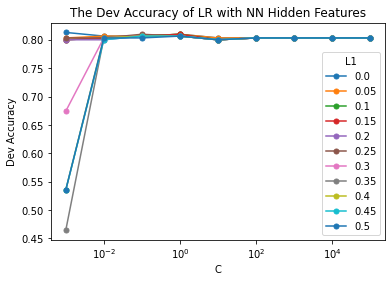

In [76]:
# lr_df = pd.DataFrame({'L2': fs_list,'L1': se_list, 'Accuracy' : lr_hidden_accuracy}, 
#                      columns=['L1','L2', 'Accuracy'])

# groups = lr_df.groupby('L1')
# fig, ax = plt.subplots()
# for name, group in groups:
#     ax.plot(group.L2, group.Accuracy, marker='o', linestyle='-', ms=5, label=name)
# ax.legend(title="L1", loc='lower right')
# ax.set_xlabel('C')
# ax.set_ylabel('Dev Accuracy')
# ax.set_title('The Dev Accuracy of LR with NN Hidden Features')
# plt.xscale('log')
# plt.show()

#### Choose best model

In [235]:
# print("Best hyperparameter:")
# for i in range(len(lr_hidden_accuracy)):
#     if lr_hidden_accuracy[i] == max(lr_hidden_accuracy):
#         print(lr_hidden_hyperparameter[i])

Best hyperparameter:
(0.001, 0.0)


In [36]:
lr_hidden = LogisticRegression(C=0.001, l1_ratio=0, penalty="elasticnet", solver="saga", max_iter=200).fit(X=x_train_feature, y=y_train)
lr_hidden_pred = lr_hidden.predict(x_dev_feature)

evaluate_dev_accuracy(lr_hidden_pred)

0.8129032258064516

### 3.2.6 Ensemble Model

In [37]:
def ensemble_predict(x_nn, x_sklearn, nn_model, sklearn_models):
    # all models need to be fitted.
    nn_pred = (nn_model.predict(x_nn) > 0.5).astype(int).reshape(-1)
    
    predict_results = [nn_pred]
    for model in sklearn_models:
        predict_results.append(model.predict(x_sklearn))
    return np.stack(predict_results).T

def vote_predicts(preds):
    return mode(preds, axis=1)[0].reshape(-1)

def build_ensemble_model(nn_model, sklearn_models):
    def wrapper(x_nn, x_sklearn):      
        return ensemble_predict(x_nn, x_sklearn, nn_model, sklearn_models)
    return wrapper

In [38]:
ensemble_model = build_ensemble_model(nn, [svc_hidden, knn_hidden, rf_hidden, lr_hidden])

preds = ensemble_model(x_dev_tfidf, x_dev_feature)
preds_ensemble = vote_predicts(preds)
evaluate_dev_accuracy(preds_ensemble)

0.8161290322580645

In experiments, if the result is nice, the NN model will be saved in `model_tfidf.h5`.

In [39]:
nn.save("model_tfidf.h5")

In [40]:
nn = load_model("model_tfidf.h5")

# 4 Evaluate and Model Comparison

## 4.1 Calculate Accuracy for Test Data

Read real test labels from `test_labels.csv`

In [41]:
# read test real labels
test = pd.read_csv("test_labels.csv")
y_test = (pd.read_csv("test_labels.csv").gender == "male").to_numpy().astype(int)

# define a function that can evaluate accuracy with test data
evaluate_test_accuracy = evaluate_accuracy(test)

def predict_and_evaluate_test_accuracy(model, x_test):
    return evaluate_test_accuracy(model.predict(x_test))

Define the partial functions from to fit models for hidden features or TF-IDF features separately.

In [42]:
predict_and_evaluate_test_accuracy_for_hidden = partial(predict_and_evaluate_test_accuracy, x_test=x_test_feature)
predict_and_evaluate_test_accuracy_for_tfidf = partial(predict_and_evaluate_test_accuracy, x_test=x_test_tfidf)

Collect the models as list, and then get the accuracy in test data.

In [43]:
# collect models as a list
sklearn_models = [svc_tfidf, knn_tfidf, rf_tfidf, lr_tfidf,
                  svc_hidden, knn_hidden, rf_hidden, lr_hidden]

# calculate test accuracy for each model
# sklearn models
sklearn_test_accuracy = list(map(predict_and_evaluate_test_accuracy_for_tfidf, sklearn_models[:4])) + \
    list(map(predict_and_evaluate_test_accuracy_for_hidden, sklearn_models[4:]))
# nn
nn_test_accuracy = sum((nn.predict(x_test_tfidf) > 0.5).reshape(-1) == y_test) / len(y_test)
# ensemble
ensemble_test_accuracy = evaluate_test_accuracy(vote_predicts(ensemble_model(x_test_tfidf, x_test_feature)))

# concat all accuracy and define the names of each model for visualization
model_accuracy = sklearn_test_accuracy + [nn_test_accuracy] + [ensemble_test_accuracy]
model_names = ["svc_tfidf", "knn_tfidf", "rf_tfidf", "lr_tfidf",
               "svc_hidden", "knn_hidden", "rf_hidden", "lr_hidden", "nn", "ensemble"]

## 4.2 Visualization

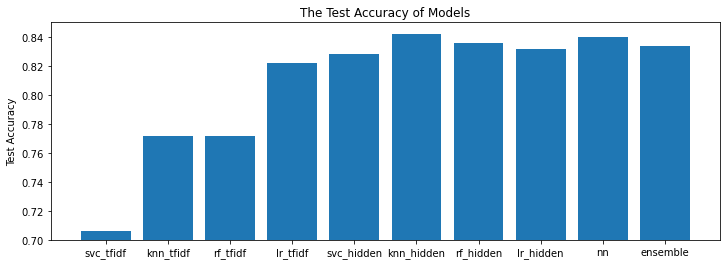

In [44]:
pos = range(len(model_accuracy))

plt.figure(figsize=(12,4))
plt.bar(pos, model_accuracy)
plt.xticks(pos, model_names)
plt.title("The Test Accuracy of Models")
plt.ylabel("Test Accuracy")
plt.ylim(0.7, 0.85)
plt.show()

## 4.3 Model Selection

Choose the best one as the result of our model

In [45]:
print("The best model is", model_names[model_accuracy.index(max(model_accuracy))])
print("The best accuracy of test data:", max(model_accuracy))

The best model is knn_hidden
The best accuracy of test data: 0.842


# 5 Output

The output file named `pred_labels.csv` will be generated.

In [59]:
# predict the labels for test data
y_test_pred = knn_hidden.predict(x_test_feature)
# add the results (0 and 1) to dataframe
test["gender"] = y_test_pred
# transfer the integer (0 and 1) to string (female and male)
test["gender"] = test.apply(lambda x: "male" if x[1] else "female", axis=1)
test

,id,gender
0,d6b08022cdf758ead05e1c266649c393,male
1,9a989cb04766d5a89a65e8912d448328,female
2,2a1053a059d58fbafd3e782a8f7972c0,male
3,6032537900368aca3d1546bd71ecabd1,male
4,d191280655be8108ec9928398ff5b563,male
...,...,...
495,22ccbc021f5647fb937a244f2b20c481,female
496,cefc8ef7699a7cdea083fb104c46b4f4,male
497,356da3bba0e1527fb5781865c45ad272,male
498,6e12611644ba86570349192a2e960e3,male


In [60]:
# generate csv file
test.to_csv("pred_labels.csv", index=None)

# 6 References

GeeksforGeeks. (2020). Removing stop words with NLTK in Python - GeeksforGeeks. Retrieved from https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

GeeksforGeeks. (2019). Python | Lemmatization with NLTK - GeeksforGeeks. Retrieved from https://www.geeksforgeeks.org/python-lemmatization-with-nltk/

James, G., Witten, Daniela, Hastie, Trevor, & Tibshirani, Robert. (2015). An introduction to statistical learning : with applications in R.

Narayan, N., & Bhalja, B. R. (2017). A Random Forest Classifier-based Digital Protection Scheme for Busbar. Electric Power Components and Systems, 45(14), 1564–1572. https://doi.org/10.1080/15325008.2017.1346003

Ozcoban, Isenkul, Güneş-Durak, Ormanci-Acar, Övez, & Tüfekci. (2018). Predicting permeability of compacted clay filtrated with landfill leachate by k-Nearest Neighbors modelling method. Water Science and Technology : a Journal of the International Association on Water Pollution Research, 77(8), 2155–2164. https://doi.org/10.2166/wst.2018.139

Stecanella, B. (2019). What is TF-IDF?. Retrieved from https://monkeylearn.com/blog/what-is-tf-idf/

